In [1]:
from collections import defaultdict

import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


Bad key "text.kerning_factor" on line 4 in
/scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from scipy.io import arff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from scipy.io import arff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [3]:
cp = pd.read_csv("../../../CenterMeanOVLP.csv") 
cp = cp.loc[:,cp.apply(pd.Series.nunique) != 1]
cp


,Unnamed: 0,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r
0,0,-53.322266,15.138672,-7.832031,0.020546,0.011831,-0.005042,0.006361,1.567715,1.506277,...,0.007785,0.019312,0.020843,-0.064662,-0.072990,-0.084042,0.215716,0.155296,0.176099,Brc1c(NC2=NCCN2)ccc2nccnc12
1,1,41.678711,1.973633,-8.867188,0.008705,0.008857,-0.001514,-0.009787,0.946463,1.437743,...,-0.018887,-0.003844,-0.019000,0.007360,0.025757,0.027188,0.088701,0.052283,0.062916,c1ccc(C(O[C@@H]2CCCN(CCc3ccc4c(c3)OCO4)C2)c2cc...
2,2,418.492188,6.976562,7.766602,0.023997,0.005404,-0.005869,-0.024194,6.252890,6.685650,...,-0.105881,0.011543,0.004370,-0.208441,-0.081369,-0.084740,-0.095445,-0.015152,-0.045636,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
3,3,-10.445312,0.101562,-0.045898,-0.003597,0.000294,0.002599,-0.001359,-0.473211,-0.001053,...,-0.024427,-0.053814,-0.040165,-0.066490,-0.036203,-0.040287,0.040549,0.026975,0.027425,c1ccc(C2CC2)c(OCC2=NCCN2)c1
4,4,48.655273,1.666992,2.486328,0.018529,0.011256,-0.002420,0.004862,1.776159,1.611745,...,0.116695,0.172022,0.164453,-0.012553,0.000800,-0.010659,0.088510,0.083851,0.076598,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,641,-133.445312,-2.585938,-4.170898,-0.006187,-0.002578,-0.001801,-0.007760,-2.365016,-2.547309,...,-0.069310,-0.098329,-0.084651,-0.048275,-0.071216,-0.062632,-0.079043,-0.088448,-0.085335,c1ccc2c(c1)[nH]c1cnccc12
642,642,-26.469727,-0.145508,-0.763672,-0.006640,-0.000166,0.001977,-0.003229,-0.770855,-0.478971,...,-0.040332,-0.035610,-0.022689,-0.003744,-0.012261,-0.003150,-0.006708,-0.009239,-0.004748,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
643,643,215.939732,2.107143,-7.992188,0.014079,0.009538,-0.005964,0.005382,3.785917,4.371880,...,-0.084987,-0.049924,-0.072038,-0.012332,0.017893,0.006418,0.005525,0.026849,0.029421,c1ccc(-c2ccc(C(c3ccccc3)n3ccnc3)cc2)cc1
644,644,1810.023438,4.320312,-1.496094,0.085425,0.025699,-0.030275,-0.063700,27.234844,31.637251,...,0.243208,0.345452,0.292939,0.108634,0.165323,0.152386,-0.089590,-0.020275,-0.033736,c1cnc2c(c1)ccc1cccnc12


In [4]:
toxcast = pd.read_csv("../../../toxcast_Overlap.csv") 

toxcast=toxcast.reindex(columns={'BSK_hDFCGF_Proliferation_down',
             'APR_HepG2_CellLoss_72h_dn',
             'BSK_3C_Proliferation_down',
             'BSK_SAg_Proliferation_down',
             'BSK_3C_SRB_down',
             'BSK_3C_Vis_down',
             'APR_HepG2_CellLoss_24h_dn',
             'BSK_LPS_SRB_down',
             'BSK_CASM3C_Proliferation_down',
             'BSK_SAg_SRB_down',
             'BSK_4H_SRB_down',
             'ACEA_T47D_80hr_Negative','smiles_r' })

toxcast=toxcast.dropna(thresh=(len(toxcast.columns)-11))

toxcast=toxcast.fillna(0)
toxcast['combined_assay']=   toxcast.BSK_SAg_Proliferation_down + toxcast.BSK_LPS_SRB_down + toxcast.ACEA_T47D_80hr_Negative + toxcast.BSK_3C_Vis_down+toxcast.APR_HepG2_CellLoss_24h_dn+toxcast.BSK_CASM3C_Proliferation_down+toxcast.BSK_4H_SRB_down+toxcast.BSK_hDFCGF_Proliferation_down+toxcast.BSK_3C_Proliferation_down+toxcast.APR_HepG2_CellLoss_72h_dn+toxcast.BSK_SAg_SRB_down+toxcast.BSK_3C_SRB_down

toxcast=toxcast[['combined_assay', 'smiles_r']]

toxcast['combined_assay']=toxcast['combined_assay']/12

toxcast['combined_assay']=toxcast['combined_assay'].apply(np.ceil)

tox_list=['combined_assay']

our_data=toxcast.reindex(columns=tox_list)
our_data

,combined_assay
9,1.0
12,0.0
15,1.0
16,1.0
19,1.0
...,...
629,1.0
633,0.0
637,1.0
640,1.0


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import cDataStructs
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit.Chem.Descriptors
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.rdMolDescriptors import *
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP #GetAvalonCountFP  #int vector version
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))



In [6]:
from sklearn.feature_selection import VarianceThreshold



In [7]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [8]:
from sklearn.feature_selection import VarianceThreshold
from numpy  import array



In [9]:
from scipy import stats
from scipy.stats import ks_2samp 
#Calculates a point biserial correlation coefficient and the associated p-value.

    


In [10]:
from sklearn.preprocessing import LabelBinarizer # one hot encoding
from sklearn.preprocessing import PolynomialFeatures # add polynomial features
from sklearn.linear_model import LogisticRegression
import seaborn as sns
 #Grid Search with Cross Validation RF
from sklearn import metrics


from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search

In [11]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold

In [12]:
def GetExactMolWt(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.ExactMolWt (mol))
def GetCalcTPSA(s):
    mol = Chem.MolFromSmiles(s)
    return (Chem.rdMolDescriptors.CalcTPSA(mol))
def GetNumRotatableBonds(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumRotatableBonds (mol))
def GetNumHDonors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHDonors(mol))
def GetNumHAcceptors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHAcceptors(mol) )
def GetMolLogP(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.MolLogP(mol))

Start
1.0    86
0.0    49
Name: combined_assay, dtype: int64


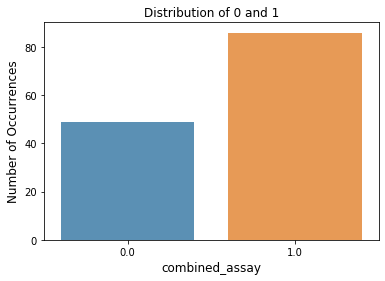

Total Compounds in Assay:  135
135
135
Total Selected CP features:  81
Total Selected train:  108
Total Selected test:  27
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   15.5s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   36.0s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.7min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.5min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.4min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.5min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.7min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.7min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 5  4]
 [ 4 14]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.56      0.56      0.56         9
         1.0       0.78      0.78      0.78        18

    accuracy                           0.70        27
   macro avg       0.67      0.67      0.67        27
weighted avg       0.70      0.70      0.70        27

Total Selected CP features:  94
Total Selected train:  108


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   10.2s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   30.6s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.4min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.5min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.6min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.7min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 4  6]
 [ 7 10]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.36      0.40      0.38        10
         1.0       0.62      0.59      0.61        17

    accuracy                           0.52        27
   macro avg       0.49      0.49      0.49        27
weighted avg       0.53      0.52      0.52        27

Total Selected CP features:  14
Total Selected train:  

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   29.9s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:   59.6s
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.3min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.5min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.4min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 8  2]
 [ 4 13]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        10
         1.0       0.87      0.76      0.81        17

    accuracy                           0.78        27
   macro avg       0.77      0.78      0.77        27
weighted avg       0.79      0.78      0.78        27

Total Selected CP features:  74
Total Selected tr

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   10.0s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   31.0s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.7min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.5min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  4.4min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  5.6min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  6.6min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 2  8]
 [ 1 16]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.20      0.31        10
         1.0       0.67      0.94      0.78        17

    accuracy                           0.67        27
   macro avg       0.67      0.57      0.54        27
weighted avg       0.67      0.67      0.61        27

Total Selected CP features:  91
Total Selected train:  108

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   10.8s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   31.9s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1378 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 1905 tasks      | elapsed:  3.0min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  3.6min
[Parallel(n_jobs=40)]: Done 3201 tasks      | elapsed:  4.3min
[Parallel(n_jobs=40)]: Done 3840 out of 3840 | elapsed:  4.8min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
In this fold
conf_matrix: 
  [[ 4  6]
 [ 5 12]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.44      0.40      0.42        10
         1.0       0.67      0.71      0.69        17

    accuracy                           0.59        27
   macro avg       0.56      0.55      0.55        27
weighted avg       0.58      0.59      0.59        27



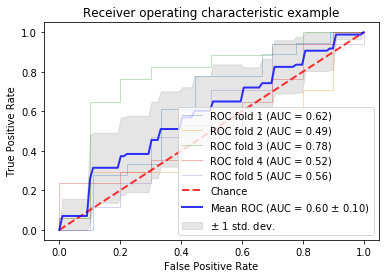

Mean of Each fold


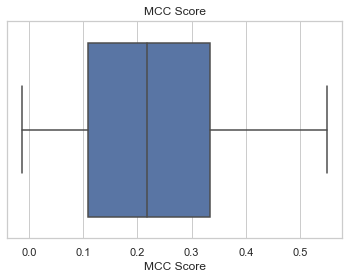

Matthews_corrcoef all:  [0.3333333333333333, -0.011562432251572007, 0.5487954724560282, 0.21693045781865616, 0.1084652289093281]
Matthews_corrcoef mean:  0.23919241205315478


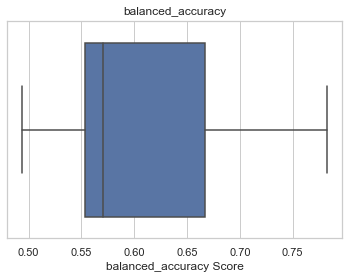

balanced_accuracy all:  [0.6666666666666667, 0.49411764705882355, 0.7823529411764706, 0.5705882352941176, 0.5529411764705883]
balanced_accuracy mean:  0.6133333333333333


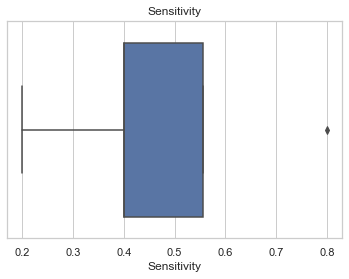

Sensitivity all:  [0.5555555555555556, 0.4, 0.8, 0.2, 0.4]
Sensitivity mean:  0.47111111111111115


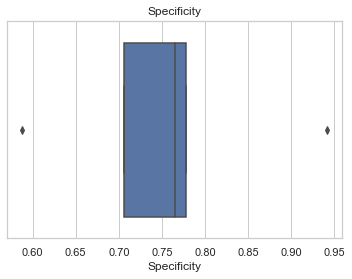

Specificity all:  [0.7777777777777778, 0.5882352941176471, 0.7647058823529411, 0.9411764705882353, 0.7058823529411765]
Specificity mean:  0.7555555555555555
One Combined Confusion Matrix
conf_matrix: 
  [[23 26]
 [21 65]]
classification_report: 
               precision    recall  f1-score   support

         0.0       0.52      0.47      0.49        49
         1.0       0.71      0.76      0.73        86

    accuracy                           0.65       135
   macro avg       0.62      0.61      0.61       135
weighted avg       0.64      0.65      0.65       135

matthews_corrcoef
0.2310318801235925
balanced_accuracy_score
0.6126008542952065
Sensitivity
0.46938775510204084
Specificity
0.7558139534883721
AUC-ROC for the combined results: 
Combined Model AUC ROC:  0.6074988134788799


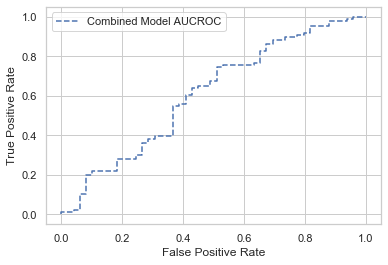

In [15]:
list_of_lists = []

for col in tox_list:
    
    method = "Morgan+CP_KS_0.02"
    
    print("Start")
    toxcast_counts=our_data[col].value_counts()
    print(our_data[col].value_counts())
    pyplot.figure()
    sns.barplot(toxcast_counts.index, toxcast_counts.values, alpha=0.8)
    pyplot.title('Distribution of 0 and 1')
    pyplot.ylabel('Number of Occurrences', fontsize=12)
    pyplot.xlabel(col, fontsize=12)
    pyplot.show()
    
    if col=='ACEA_T47D_80hr_Negative':
        n_cluster=4
    else:
        n_cluster=5  
        
    
    target=col

    df_temp=pd.merge(cp, toxcast[[target, 'smiles_r']], left_on = 'smiles_r', right_on = 'smiles_r', how = 'inner')
    df_temp['MorganFingerprint'] =df_temp['smiles_r'].apply(MorganFingerprint)
    df_temp=df_temp.dropna(subset=[target])
    df_temp=df_temp.drop('Unnamed: 0', axis = 1)
    
    
    X_erg = np.array([x for x in df_temp['MorganFingerprint']])
    
    
    data=df_temp 
    data=data.drop('MorganFingerprint', axis = 1)
    data=data.drop('smiles_r', axis = 1)
    

    
    X_CP, y = data.loc[:, data.columns != target], data[target]

    X_CP=X_CP.to_numpy()
    
    y=y.to_numpy()
        
    print("Total Compounds in Assay: ", len(y))
    X= np.concatenate((X_CP, X_erg ), axis=1)
    
    print(len(X))
    print(len(y))
    
    outercv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    
    mat_cof=[]
    ba=[]
    sen=[]
    spe=[]
    combined_y_test=[]
    combined_y_pred=[]
    
    for i, (train_index, test_index) in enumerate(outercv.split(X, y)):
        
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train_erg=X_train[:, 1766:]
        X_test_erg=X_test[:, 1766:]
        
        rows_train_CP= np.concatenate((X_train[:, :1766], y_train[:,None]),axis=1)
        new_df_train_CP = pd.DataFrame(rows_train_CP, columns=data.columns)
        
        rows_test_CP= np.concatenate((X_test[:, :1766], y_test[:,None]),axis=1)
        new_df_test_CP = pd.DataFrame(rows_test_CP, columns=data.columns)
        
        arr=[]
        col_list=[]

        for num in new_df_train_CP.columns:
        
            inactives=new_df_train_CP[num][new_df_train_CP[target]==0]
            actives=new_df_train_CP[num][new_df_train_CP[target]==1]
       
            if (ks_2samp(inactives, actives)[1] <= 0.02):
                col_list.append(num)
        
        print("Total Selected CP features: ",  len(col_list))
        

        train_data_CP=new_df_train_CP[col_list]
        test_data_CP=new_df_test_CP[col_list]
    
        X_train_CP= train_data_CP.loc[:, train_data_CP.columns != target]
        X_train_CP=X_train_CP.to_numpy()
        
        X_test_CP= test_data_CP.loc[:, test_data_CP.columns != target]
        X_test_CP=X_test_CP.to_numpy()
        
        X_train= np.concatenate((X_train_CP, X_train_erg ), axis=1)
        X_test= np.concatenate((X_test_CP, X_test_erg ), axis=1)
        
        print("Total Selected train: ",  len(X_train))
        print("Total Selected test: ",  len(X_test))
        
        inner_cv = StratifiedKFold(n_splits=n_cluster, shuffle=True, random_state=0)
               
        param_grid = { 
        'max_depth': [15, 10, 20],
        'max_features': ['auto'],
        'min_samples_leaf': [3, 6, 12, 15],
        'min_samples_split': [6, 9, 12, 15],
        'n_estimators':[100, 200, 300, 700],
        'bootstrap': [False],
        'oob_score': [False],
        'random_state': [0],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
        'class_weight' : [None, 'balanced']
        }

        # Create a based model
        rf = RandomForestClassifier()
        # Instantiate the grid search model
        grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                  cv = inner_cv, n_jobs =40, verbose = 2)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)
        print(grid_search.best_estimator_)

        classifier = grid_search.best_estimator_
        
        
        
        classifier.fit(X_train, y_train)
       
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)
       
        combined_y_test=np.concatenate((combined_y_test, y_test), axis=None)
        combined_y_pred=np.concatenate((combined_y_pred, y_pred), axis=None)
        
        if i==0:
            combined_y_proba=y_proba
        else:
            combined_y_proba=np.concatenate((combined_y_proba, y_proba), axis=0)
    
    
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("In this fold")
        print("conf_matrix: \n " , conf_matrix)
        print("classification_report: \n",classification_report(y_test, y_pred))
    
        mat_cof.append(matthews_corrcoef(y_test, y_pred))
        ba.append(balanced_accuracy_score(y_test, y_pred))
        
        sen.append(conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]))
        spe.append(conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]))

        
        viz = plot_roc_curve(classifier, X_test, y_test,
                             name='ROC fold {}'.format(1+i),
                             alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()
    
    print("Mean of Each fold")
       
    sns.set(style="whitegrid")    
    sns.boxplot(x=mat_cof).set(title = 'MCC Score', xlabel = 'MCC Score' )
    plt.show()
    print("Matthews_corrcoef all: ",(mat_cof))
    print("Matthews_corrcoef mean: ", np.mean(mat_cof))
    
    sns.boxplot(x=ba).set(title = 'balanced_accuracy', xlabel = 'balanced_accuracy Score' )
    plt.show() 
    print("balanced_accuracy all: ",(ba))
    print("balanced_accuracy mean: ", np.mean(ba))
        
    sns.boxplot(x=sen).set(title = 'Sensitivity', xlabel = 'Sensitivity' )
    plt.show()
    print("Sensitivity all: ",(sen))
    print("Sensitivity mean: ", np.mean(sen))
        
    sns.boxplot(x=spe).set(title = 'Specificity', xlabel = 'Specificity' )
    plt.show()
    print("Specificity all: ",(spe))
    print("Specificity mean: ", np.mean(spe))
    
    
    
    print("One Combined Confusion Matrix")
    combined_conf_matrix = confusion_matrix(combined_y_test, combined_y_pred)
    print("conf_matrix: \n " , combined_conf_matrix)
    print("classification_report: \n",classification_report(combined_y_test, combined_y_pred))
    
    print('matthews_corrcoef')
    mcc= matthews_corrcoef(combined_y_test, combined_y_pred)
    print(mcc)
    
    print('balanced_accuracy_score')
    ba= balanced_accuracy_score(combined_y_test, combined_y_pred)
    print(ba)
    
    print('Sensitivity')   
    sen=combined_conf_matrix[0,0]/(combined_conf_matrix[0,0]+combined_conf_matrix[0,1])
    print(sen)
    
    print('Specificity')  
    spe=combined_conf_matrix[1,1]/(combined_conf_matrix[1,0]+combined_conf_matrix[1,1])
    print(spe)
       
    print("AUC-ROC for the combined results: ")
    probs_combined_model= combined_y_proba[:,1]
    roc_value_combined_model= roc_auc_score(combined_y_test, probs_combined_model) 
    print("Combined Model AUC ROC: ", roc_value_combined_model)
    
    base_model_fpr, base_model_tpr, _ = roc_curve(combined_y_test, probs_combined_model)
    plt.plot(base_model_fpr, base_model_tpr, linestyle='--', label='Combined Model AUCROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    row=[col, method, sen, spe, ba, mcc, roc_value_combined_model]
    list_of_lists.append(row)

In [16]:
df=pd.DataFrame(list_of_lists,columns=["target", "method", "sen", "spe", "ba", "mcc", "auc_roc"])
df

,target,method,sen,spe,ba,mcc,auc_roc
0,combined_assay,Morgan+CP_KS_0.02,0.469388,0.755814,0.612601,0.231032,0.607499


In [17]:
file_name="Metrics_KFold_Aggregated"+method+".csv"
df.to_csv(file_name)